# Exploratory Data Analysis of FCDO Trucks Project

---

Fan Grayson

For Code Review

## Introduction

This mini-project is a case study of the ["Detecting Trucks in East Africa"](https://datasciencecampus.ons.gov.uk/detecting-trucks-in-east-africa/) project done by the ONS and the FCDO.

This mini-project includes the following data provided by the ONS:

1. __Images:__ .tiff images from the Sentinel 2 satellite of the A1 road north of Windhoek, Namibia, edited by the ONS
2. __Image chips:__ NumPy masked arrays encoding small sections of the images from the satellite images
3. __Tabular data:__ .csv table containing information for a selection of image pixels, with additional features the ONS has inferred

This notebook explores each of these data

## Setup

Importing packages and setting up notebook

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tf
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=15)

## Image Data

 - Satellite image from Sentinel 2 (open source, updated every 5-10 days)
 - Image is of stretch of A1 road north of Windhoek, Namibia
 - Pixels that are not of the A1 road have been masked and removed
 - Pixels that have a high cloud coverage have also been masked and removed
 - Data is given in the .tiff file format
 - There are 4 channels (layers) in each image: RGB + near-infrared [(see here)](https://gisgeography.com/sentinel-2-bands-combinations/)
 - Each pixel is 10 x 10 m

In [2]:
# Loading all available tiff images in ../data as masked numpy arrays
image_filenames = [x for x in os.listdir("../data") if x.endswith(".tif")]
images = [
    np.ma.masked_values(tf.imread(os.path.join("..", "data", f)), -999.00)
    for f in image_filenames
    ]

In [3]:
def plot_tiff_image(
        image: np.array,
        x_min:int = 0,
        x_max:int = None,
        y_min:int = 0,
        y_max:int = None,
        channels:list = [0,1,2],
        background:float = 0.5,
        title:str = "",
        ):
    """Plots satellite image from numpy array"""

    # Either one (monochrome) or three (RGB) channels

    if not isinstance(channels, list):
        channels = list(channels)

    assert (len(channels) == 1) or (len(channels) == 3)

    fig, ax = plt.subplots()
    fig.set_figheight(30)

    ax.imshow(image[y_min:y_max, x_min:x_max, channels].filled(background))
    ax.set_title(title)
    ax.set_axis_off()

    scalebar = AnchoredSizeBar(ax.transData,
                            100, '1 km', 'upper right', 
                            pad=0.5,
                            color='white',
                            frameon=False,
                            size_vertical=5,
                            fontproperties=fontprops)

    ax.add_artist(scalebar)

    plt.show()

The entire (edited) image looks like this:

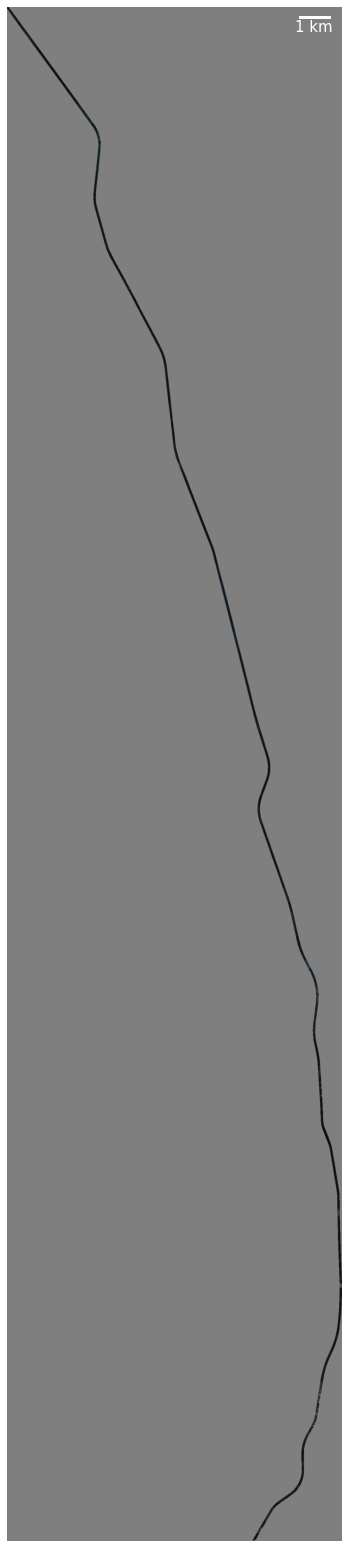

In [4]:
plot_tiff_image(images[0])

We can focus on a small section of road

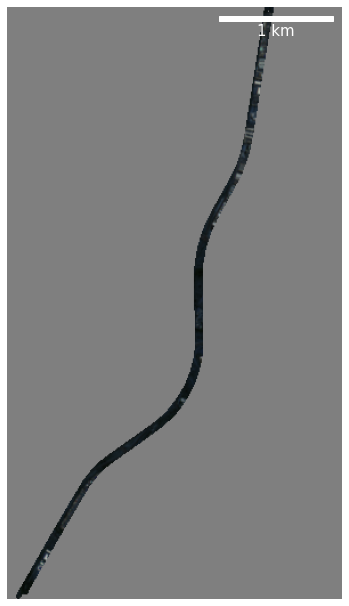

In [5]:
plot_tiff_image(images[0], x_min=780, y_min=4400)

 - Looking closer, we can see some of the possible 'rainbow effect' of large vehicles.
 - This happens since there is a delay in the satellite capturing Red, Green, and Blue channels
 - So large moving pixels will have a 'rainbow effect' (see the [ONS article for more information](https://datasciencecampus.ons.gov.uk/detecting-trucks-in-east-africa/))

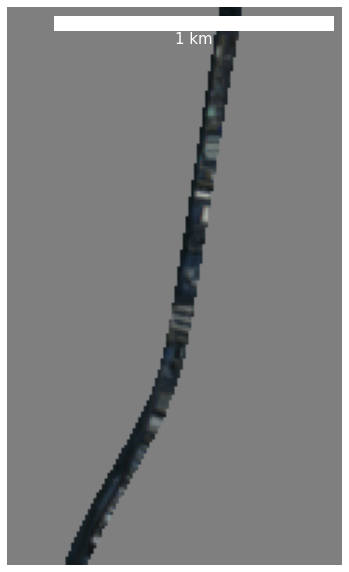

In [6]:
plot_tiff_image(images[0], x_min=930, x_max=1050, y_min=4400, y_max=4600)

## Image Chips

In [7]:
image_chip_filenames = os.listdir("../data/chips/")

In [8]:
i = 11
image_chip = np.load(os.path.join("../data/chips", image_chip_filenames[i]), allow_pickle=True)
print(image_chip_filenames[i])
image_chip.shape

windhoek_2021-04-21__384_8320


(28, 128, 128)

## Tabular Dataset

Loading in the tabular data & looking at features

In [9]:
# load in the features csv file
df = pd.read_csv("../data/all_training_features.csv")

In [10]:
# Exploring first few rows
df.head(3)

,Unnamed: 0,blue,green,red,bg_change,br_change,gr_change,bg_z,br_z,gr_z,...,green_max_temp5,red_max_temp5,greenblue_max5,redblue_max5,greenblue_max_temp5,redblue_max_temp5,validation,ml_class,date,location
0,168676,1.0536,0.9664,0.9328,1.053600,1.053600,0.349470,1.053600,1.053600,1.865255,...,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,0.0,2019-10-01,nairobi
1,393513,0.0999,0.1226,0.1362,-0.012760,-0.005751,0.539186,-0.666817,-0.270743,1.889493,...,183.0,168.0,195.0,177.0,166.0,193.0,-999.0,0.0,2020-12-14,nairobi
2,394447,0.0954,0.1102,0.1282,0.009269,-0.003518,0.626979,0.125706,-0.203395,1.745019,...,232.0,180.0,183.0,202.0,189.0,195.0,-999.0,0.0,2020-12-14,nairobi


In [11]:
# Print out engineered features
set("_".join(c.split("_")[1:]) for c in df.columns)
    

{'', 'change', 'class', 'max', 'max5', 'max_temp', 'max_temp5', 'pixel', 'z'}

This is a highly imbalanced dataset (intuitively, the majority of the non-masked pixels in the image are not trucks)

In [12]:
# Check Imbalance:
print(f"Class 1: {sum(df.ml_class == 1.0)} ({round(100 * sum(df.ml_class == 1.0) / len(df), 2)}%)")
print(f"Class 0: {sum(df.ml_class == 0.0)}")

Class 1: 365 (0.22%)
Class 0: 166604
